# 使用 TensorBoard 可视化模型、数据和训练

译文：https://pytorch.apachecn.org/2.0/tutorials/intermediate/tensorboard_tutorial
原文：https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

本教程使用 Fashion-MNIST 数据集展示如何在 PyTorch 中使用 TensorBoard 可视化模型、数据和训练过程。你将学会：

- 读入数据并进行适当的转换
- 设置并写入 TensorBoard
- 在 TensorBoard 中查看模型结构（Graphs）
- 使用 Projector 可视化高维数据
- 在训练时跟踪指标与可视化预测
- 在评估时绘制精确率-召回率曲线（PR Curves）

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# datasets
trainset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=True, transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=False, transform=transform
)

# dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2
)

# constant for classes
classes = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
)

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

100%|██████████| 26.4M/26.4M [24:05<00:00, 18.3kB/s]

100%|██████████| 29.5k/29.5k [00:00<00:00, 64.6kB/s]

100%|██████████| 4.42M/4.42M [00:02<00:00, 1.75MB/s]

100%|██████████| 5.15k/5.15k [00:00<00:00, 3.92MB/s]



In [3]:
# model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Logged image grid to TensorBoard


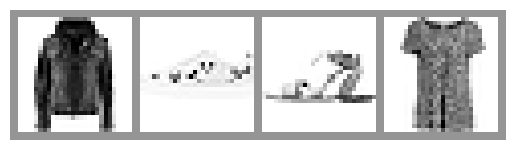

In [4]:
# 1) TensorBoard 设置与写入图像网格
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images inline (optional)
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)
print('Logged image grid to TensorBoard')

### 启动 TensorBoard（可选）

在终端运行以下命令，然后在浏览器打开 http://localhost:6006 查看：

```bash
tensorboard --logdir=runs
```

当你运行上面的“写入图像网格”的单元后，即可在 TensorBoard 的 Images 标签中查看写入的图片。

In [5]:
# 2) 使用 TensorBoard 检查模型（Graphs）
# 注意：需要提供一个样例 batch 作为输入来记录计算图
writer.add_graph(net, images)
writer.flush()
print('Logged model graph to TensorBoard')

Logged model graph to TensorBoard


In [6]:
# 3) 添加 Projector（Embedding）
# helper function

def select_n_random(data, labels, n=100):
    """
    Selects n random datapoints and their corresponding labels from a dataset
    """
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images_raw, labels_raw = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab.item()] for lab in labels_raw]

# log embeddings
features = images_raw.view(-1, 28 * 28).float()
writer.add_embedding(
    features,
    metadata=class_labels,
    label_img=images_raw.unsqueeze(1).float(),
)
writer.flush()
print('Logged embeddings to TensorBoard Projector')

Logged embeddings to TensorBoard Projector


In [7]:
# 4) 使用 TensorBoard 跟踪模型训练

def images_to_probs(net, images):
    """
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    """
    with torch.no_grad():
        output = net(images)
        # convert output probabilities to predicted class
        _, preds_tensor = torch.max(output, 1)
        preds = np.squeeze(preds_tensor.numpy())
        probs = [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]
    return preds, probs


def plot_classes_preds(net, images, labels):
    """
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    """
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 4))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(
            "{0}, {1:.1f}% (label: {2})".format(
                classes[preds[idx]], probs[idx] * 100.0, classes[labels[idx]]
            ),
            color=("green" if preds[idx] == labels[idx].item() else "red"),
        )
    fig.tight_layout()
    return fig

# train for 1 epoch and log running loss every 1000 batches, plus prediction figures
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:  # every 1000 mini-batches...
            # ...log the running loss
            writer.add_scalar(
                'training loss', running_loss / 1000, epoch * len(trainloader) + i
            )
            # ...log a Matplotlib Figure showing predictions vs actuals
            writer.add_figure(
                'predictions vs. actuals',
                plot_classes_preds(net, inputs, labels),
                global_step=epoch * len(trainloader) + i,
            )
            running_loss = 0.0

print('Finished Training (logged scalars and figures)')

Finished Training (logged scalars and figures)


In [8]:
# 5) 使用 TensorBoard 评估训练后的模型（PR Curves）
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~some seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper to add PR curve for a single class

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    """
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    """
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(
        classes[class_index], tensorboard_truth, tensorboard_probs, global_step=global_step
    )
    writer.flush()

# plot all PR curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

print('Logged PR curves to TensorBoard')

# close writer at the end
writer.close()

Logged PR curves to TensorBoard
